# Basic ViT

This notebook contains code (to be refactored into scripts at a later stage) that implements a basic ViT to be trained on CIFAR10 and CIFAR100. 

In [65]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time

# Machine learning imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor, optim
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Third-party imports
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [66]:
# Function that sets device to either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
def set_device():
    # Set device: either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device

In [67]:
def simple_transform():
    '''Return a simple transformation for validation/testing.'''
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform

In [68]:
def data_loader(dataset: str, batch_size: int, image_size: int, augment: bool = True):
    '''
    Function that takes in a dataset and returns train and test dataloaders along with the hyperparameters
    associated with the dataset.

    Parameters:
        dataset (str): Name of dataset to load. Options: MNIST, CIFAR10, CIFAR100
        batch_size (int): Batch size for dataloaders
        augment (bool): Whether to augment training data or not
        
    Returns:
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        test_loader (DataLoader): Dataloader for test set
        num_classes (int): Number of classes in dataset
        image_size (int): Size of image in dataset
        batch_size (int): Batch size for dataloaders
    '''

    base_train_transforms = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if dataset == "MNIST":
        base_train_transforms.append(transforms.Normalize((0.5,), (0.5,)))
    elif dataset == "CIFAR10":
        mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
        base_train_transforms.append(transforms.Normalize(mean, std))
    elif dataset == "CIFAR100":
        mean, std = (0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
        base_train_transforms.append(transforms.Normalize(mean, std))

    # Additional augmentations for CIFAR10 and CIFAR100
    additional_transforms = []
    if augment:

        additional_transforms = [
            transforms.Resize((image_size, image_size)),
            # transforms.RandomCrop(image_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(3.6),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),

        ]
    
    dataset_config = {
        'MNIST': {
            'num_classes': 10,
            'default_image_size': 28,
            'batch_size': batch_size,  # Use the batch_size parameter
            'train_transform': transforms.Compose(base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        },
        'CIFAR10': {
            'num_classes': 10,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
            ])
        },
        'CIFAR100': {
            'num_classes': 100,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
            ])
        }
    }    

    # Ensure dataset is valid
    if dataset not in dataset_config:
        raise ValueError(f"Unsupported dataset: {dataset}. Supported datasets are: {', '.join(dataset_config.keys())}")

    # Access config
    cfg = dataset_config[dataset]

    # Print loading info
    print(f'Loading {dataset} dataset...')

    # Load data
    if dataset == 'MNIST':
        dataset_cls = datasets.MNIST
    elif dataset == 'CIFAR10':
        dataset_cls = datasets.CIFAR10
    else:
        dataset_cls = datasets.CIFAR100

    train_dataset_full = dataset_cls(f'../data/{dataset}_data/', train=True, download=True, transform=cfg['train_transform'])
    test_dataset = dataset_cls(f'../data/{dataset}_data/', train=False, download=True, transform=cfg['test_transform'])

    # Split training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    # Compute optimal number of workers
    num_workers = min(4, os.cpu_count())

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, cfg['num_classes'], cfg['default_image_size'], batch_size


In [69]:
class PatchEmbedding(nn.Module):
    '''
    Class that creates patch embeddings for images
    (image to patch embeddings).

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension

    Returns:
        x (Tensor): Patch embeddings
    '''
    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Converts an input image tensor into patch embeddings.

        Args:
            x (Tensor): Input image tensor of shape (B, C, H, W).

        Returns:
            Tensor: The patch embeddings of shape (B, num_patches, embed_dim).
        """
        x = self.projection(x).flatten(2).transpose(1, 2)

        return x

In [70]:
class Attention(nn.Module):
    '''
    Class that creates an attention layer.

    Parameters:
        dim (int): Dimension of input
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of attention layer
    '''
    
    def __init__(self, 
                dim: int, 
                heads: int, 
                dim_head: int, 
                dropout: float=0.):
        super().__init__()
        
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        # Linear layer to get Q, K, V
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attend = nn.Softmax(dim=-1)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        
        # Obtain Q, K, V from input tensor x
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.dim_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores and apply scaling
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        
        # Softmax to get attention weights
        attn = self.attend(dots)
        
        # Calculate the output tensor
        out = torch.einsum('bhij,bhjd->bhid', attn, v).reshape(B, N, C)
        out = self.proj(out)
        return out


In [71]:
class MLP(nn.Module):
    '''
    Class that creates a multilayer perceptron (MLP).

    Parameters:
        in_features (int): Number of input features
        hidden_features (int, optional): Number of hidden features. Defaults to in_features.
        out_features (int, optional): Number of output features. Defaults to in_features.
        activation (nn.Module, optional): Activation function. Defaults to nn.GELU().
        drop (float, optional): Dropout probability. Defaults to 0.

    Returns:
        x (Tensor): Output of MLP
    '''
    def __init__(self, 
                 in_features: int, 
                 hidden_features: int = None, 
                 out_features: int = None, 
                 activation: nn.Module = nn.GELU(),
                 drop: float = 0.):
        super().__init__()
        
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [72]:
class TransformerEncoderBlock(nn.Module):
    '''
    Class that creates a transformer encoder block.

    Parameters:
        dim (int): Embedding dimension
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of transformer encoder block
    '''
    def __init__(self, 
                 dim: int, 
                 heads: int, 
                 dim_head: int, 
                 mlp_dim: int, 
                 dropout: float = 0.):
        super().__init__()
        
        # Layer normalization followed by attention (with residual)
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        
        # Layer normalization followed by feed-forward (with residual)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_dim, out_features=dim, drop=dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply attention, add residual connection, and apply dropout
        x = x + self.dropout1(self.attn(self.norm1(x)))
        
        # Apply MLP, add residual connection, and apply dropout
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        
        return x


In [73]:
class VisionTransformer(nn.Module):
    '''
    Vision transformer architecture.

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension
        depth (int): Depth
        heads (int): Number of heads
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability
        num_classes (int): Number of classes

    Returns:
        x (Tensor): Output of VisionTransformer
    '''

    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int, 
                 depth: int, 
                 heads: int, 
                 mlp_dim: int,
                 num_classes: int, 
                 dropout: float = 0., 
                 mlp_head_units = [2048, 1024]):
        super().__init__()        
        # Patch embedding layer
        self.patch_embed = PatchEmbedding(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        # Initializing cls_token and pos_embed with random values
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Calculate the number of patches
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))  # +1 for the cls_token --> initialising to zeros seems to work better than random values
        # self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # +1 for the cls_token
        
        self.dropout = nn.Dropout(dropout)
        self.transformer_encoder = nn.ModuleList([TransformerEncoderBlock(dim=embed_dim, heads=heads, dim_head=embed_dim // heads, mlp_dim=mlp_dim, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_head_units[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[1], num_classes)
        )

    def forward(self, x):
        B = x.shape[0]  # batch_size
        x = self.patch_embed(x)
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=B)
        x = torch.cat((cls_tokens, x), dim=1)
        
        assert x.shape[1] == self.pos_embed.shape[1], f"Positional embeddings don't match the input patches. x.shape: {x.shape} pos_embed.shape: {self.pos_embed.shape}"
        
        x = x + self.pos_embed
        x = self.dropout(x)

        for transformer_encoder in self.transformer_encoder:
            x = transformer_encoder(x)

        x = self.norm(x)
        x = x[:, 0]  # Take the cls_token representation
        x = self.mlp_head(x)

        return x



In [74]:
def train(model, train_loader, val_loader, criterion, optimizer, device, model_name,epochs=10, scheduler=None, patience=None):
    '''
    Function that trains the model.

    Parameters:
        model (nn.Module): Model to train
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        criterion (nn.Module): Loss function
        optimizer (nn.Module): Optimizer
        device (str): Device to use
        epochs (int): Number of epochs
        scheduler (nn.Module): Learning rate scheduler
        patience (int): Number of epochs to wait before early stopping
        model_name (str): Name of model

    Returns:
        model (nn.Module): Trained model
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_acc (list): Training accuracy
        val_acc (list): Validation accuracy
    '''
    
    # Set model to training mode
    model.train()

    # Initialize lists to store losses and accuracy
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_val_loss = np.inf

    epochs_without_improvement = 0  # for early stopping

    # Record the start time for training
    start_time = time.time()

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_val_loss = 0
        epoch_val_acc = 0

        # Training
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_acc += torch.sum(preds == labels.data)

        # Validation
        model.eval()  # <-- set model to eval mode for validation
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_val_acc += torch.sum(preds == labels.data)
        model.train()  # <-- set model back to train mode

        # Average metrics
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = epoch_train_acc.float() / len(train_loader.dataset)
        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = epoch_val_acc.float() / len(val_loader.dataset)

        if scheduler:
            scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0  # reset the count
        else:
            epochs_without_improvement += 1

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_val_acc:.4f}')

        # Early stopping
        if patience and epochs_without_improvement == patience:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")
    
    model.load_state_dict(best_model_wts)
    # save trained model
    torch.save(model.state_dict(), f'../trained_models/{model_name}.pth')

    return model, train_losses, val_losses, train_acc, val_acc


In [75]:
# train the model
dataset = "CIFAR100" # <-- change this parameter only! Options: MNIST, CIFAR10, CIFAR100

model_name = f"{dataset}_classifier"
in_channels = 1 if dataset == "MNIST" else 3
num_classes = 100 if dataset == "CIFAR100" else 10
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256 #if dataset == "MNIST" else 128
num_epochs = 10
image_size = 28 if dataset == "MNIST" else 32 #40 # upscale CIFAR10 and CIFAR100 images for better performance -> INVESTIGATE
patch_size = 7 if dataset == "MNIST" else 8 #10 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8 # depth
mlp_head_units = [2048, 1024]
patience_value = 5 # if dataset == "MNIST" else 5
dropout=0. # Adjust as necessary

# Set device
device = set_device()

# Load data
train_loader, val_loader, test_loader, num_classes, default_image_size, batch_size = data_loader(dataset, batch_size, image_size)

patch_embed = PatchEmbedding(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim
)

# Instantiate the classes
attention = Attention(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads)
mlp = MLP(in_features=projection_dim, hidden_features=transformer_units[0], out_features=transformer_units[1])
transformer_encoder_block = TransformerEncoderBlock(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads, mlp_dim=transformer_units[0])

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes
).to(device)

# Print model summary
# summary(model.cpu(), input_size=(in_channels, image_size, image_size))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.1, verbose=True)

# Train model
model, train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=num_epochs, scheduler=scheduler, patience=patience_value)

Using mps device
Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 1/10 - Train Loss: 4.3066, Train Acc: 0.0400, Val Loss: 4.1651, Val Acc: 0.0550


Epoch 2/10 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 2/10 - Train Loss: 4.0617, Train Acc: 0.0691, Val Loss: 4.0109, Val Acc: 0.0771


Epoch 3/10 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Epoch 3/10 - Train Loss: 3.8970, Train Acc: 0.0916, Val Loss: 3.8267, Val Acc: 0.1059


Epoch 4/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 4/10 - Train Loss: 3.7681, Train Acc: 0.1122, Val Loss: 3.7670, Val Acc: 0.1110


Epoch 5/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 5/10 - Train Loss: 3.6626, Train Acc: 0.1313, Val Loss: 3.6893, Val Acc: 0.1302


Epoch 6/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 6/10 - Train Loss: 3.5687, Train Acc: 0.1472, Val Loss: 3.5719, Val Acc: 0.1509


Epoch 7/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 7/10 - Train Loss: 3.4968, Train Acc: 0.1585, Val Loss: 3.4868, Val Acc: 0.1704


Epoch 8/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 8/10 - Train Loss: 3.4363, Train Acc: 0.1708, Val Loss: 3.4952, Val Acc: 0.1668


Epoch 9/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 9/10 - Train Loss: 3.3775, Train Acc: 0.1813, Val Loss: 3.4168, Val Acc: 0.1785


Epoch 10/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]

Epoch 10/10 - Train Loss: 3.3281, Train Acc: 0.1908, Val Loss: 3.3996, Val Acc: 0.1848
Total training time: 14.26 minutes


In [ ]:
# PLACEHOLDER

# Basic ViT on MNIST

```
Using mps device
Loading MNIST dataset...
Epoch 1/10 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.58it/s]
Epoch 1/10 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.37it/s]
Epoch 1/10 - Train Loss: 0.9125, Train Acc: 0.6762, Val Loss: 0.3476, Val Acc: 0.8909
Epoch 2/10 [Training]: 100%|██████████| 188/188 [00:34<00:00,  5.39it/s]
Epoch 2/10 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.09it/s]
Epoch 2/10 - Train Loss: 0.2448, Train Acc: 0.9242, Val Loss: 0.2064, Val Acc: 0.9362
Epoch 3/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.71it/s]
Epoch 3/10 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.18it/s]
Epoch 3/10 - Train Loss: 0.1677, Train Acc: 0.9482, Val Loss: 0.1616, Val Acc: 0.9492
Epoch 4/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.72it/s]
Epoch 4/10 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.45it/s]
Epoch 4/10 - Train Loss: 0.1295, Train Acc: 0.9596, Val Loss: 0.1371, Val Acc: 0.9577
Epoch 5/10 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.64it/s]
Epoch 5/10 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  9.14it/s]
Epoch 5/10 - Train Loss: 0.1198, Train Acc: 0.9622, Val Loss: 0.1273, Val Acc: 0.9608
Epoch 6/10 [Training]: 100%|██████████| 188/188 [00:33<00:00,  5.60it/s]
Epoch 6/10 [Validation]: 100%|██████████| 47/47 [00:05<00:00,  8.98it/s]
Epoch 6/10 - Train Loss: 0.1052, Train Acc: 0.9670, Val Loss: 0.1399, Val Acc: 0.9563
Epoch 7/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]
Epoch 7/10 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.00it/s]
Epoch 7/10 - Train Loss: 0.0952, Train Acc: 0.9697, Val Loss: 0.1290, Val Acc: 0.9606
Epoch 8/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.86it/s]
Epoch 8/10 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.13it/s]
Epoch 8/10 - Train Loss: 0.0930, Train Acc: 0.9706, Val Loss: 0.1182, Val Acc: 0.9624
Epoch 9/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.85it/s]
Epoch 9/10 [Validation]: 100%|██████████| 47/47 [00:04<00:00,  9.97it/s]
Epoch 9/10 - Train Loss: 0.0769, Train Acc: 0.9755, Val Loss: 0.1077, Val Acc: 0.9652
Epoch 10/10 [Training]: 100%|██████████| 188/188 [00:32<00:00,  5.87it/s]
Epoch 10/10 [Validation]: 100%|██████████| 47/47 [00:04<00:00, 10.05it/s]
Epoch 10/10 - Train Loss: 0.0771, Train Acc: 0.9762, Val Loss: 0.0968, Val Acc: 0.9708
Total training time: 6.32 minutes
```

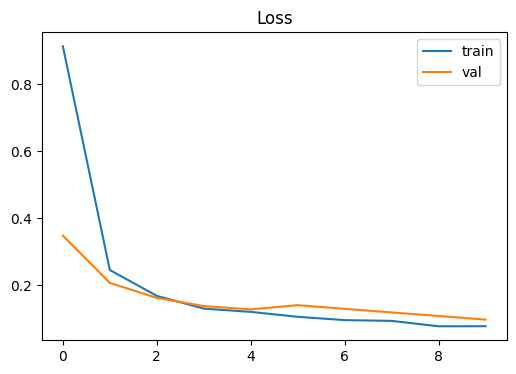

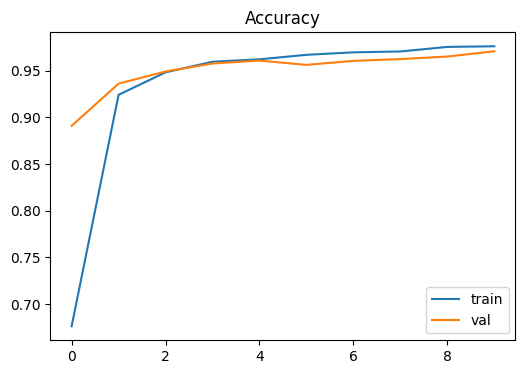

In [63]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

Testing: 40it [00:05,  7.91it/s]

Test accuracy: 0.9712
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.96      0.97       892
           6       0.95      0.98      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



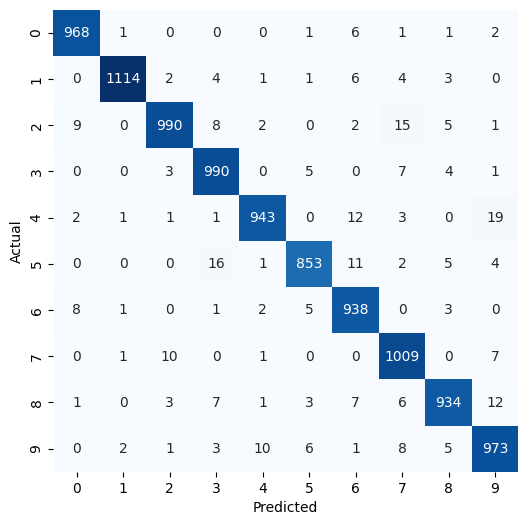

In [64]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Basic ViT on CIFAR10

```
Using mps device
Loading CIFAR10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 [Training]: 100%|██████████| 157/157 [00:56<00:00,  2.77it/s]
Epoch 1/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 1/10 - Train Loss: 2.0720, Train Acc: 0.2055, Val Loss: 1.9485, Val Acc: 0.2732
Epoch 2/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 2/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 2/10 - Train Loss: 1.9053, Train Acc: 0.2862, Val Loss: 1.8633, Val Acc: 0.3131
Epoch 3/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 3/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 3/10 - Train Loss: 1.8012, Train Acc: 0.3326, Val Loss: 1.7921, Val Acc: 0.3351
Epoch 4/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 4/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 4/10 - Train Loss: 1.7301, Train Acc: 0.3612, Val Loss: 1.6873, Val Acc: 0.3746
Epoch 5/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 5/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 5/10 - Train Loss: 1.6707, Train Acc: 0.3852, Val Loss: 1.6393, Val Acc: 0.4068
Epoch 6/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
Epoch 6/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Epoch 6/10 - Train Loss: 1.6340, Train Acc: 0.3983, Val Loss: 1.6151, Val Acc: 0.4040
Epoch 7/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 7/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 7/10 - Train Loss: 1.5878, Train Acc: 0.4212, Val Loss: 1.5575, Val Acc: 0.4276
Epoch 8/10 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.84it/s]
Epoch 8/10 [Validation]: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]
Epoch 8/10 - Train Loss: 1.5618, Train Acc: 0.4298, Val Loss: 1.5776, Val Acc: 0.4192
Epoch 9/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 9/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]
Epoch 9/10 - Train Loss: 1.5241, Train Acc: 0.4450, Val Loss: 1.5223, Val Acc: 0.4482
Epoch 10/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch 10/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 10/10 - Train Loss: 1.5136, Train Acc: 0.4480, Val Loss: 1.5038, Val Acc: 0.4614
Total training time: 14.38 minutes
```

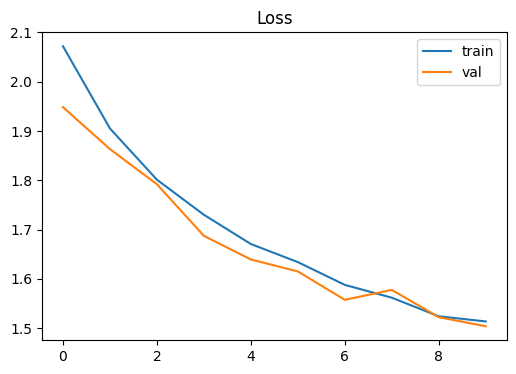

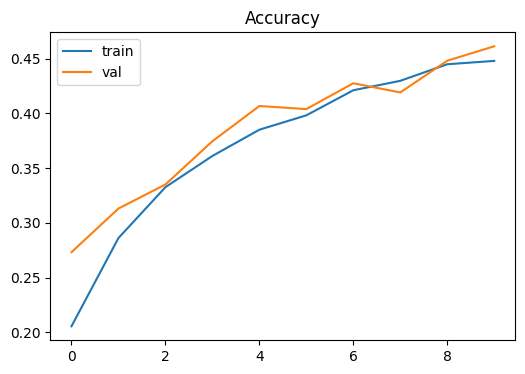

In [39]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

Testing: 40it [00:23,  1.74it/s]


Test accuracy: 0.4714
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      1000
           1       0.56      0.58      0.57      1000
           2       0.36      0.31      0.33      1000
           3       0.32      0.22      0.26      1000
           4       0.45      0.38      0.41      1000
           5       0.40      0.46      0.43      1000
           6       0.50      0.48      0.49      1000
           7       0.50      0.55      0.52      1000
           8       0.54      0.66      0.60      1000
           9       0.49      0.53      0.51      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.47     10000
weighted avg       0.46      0.47      0.47     10000



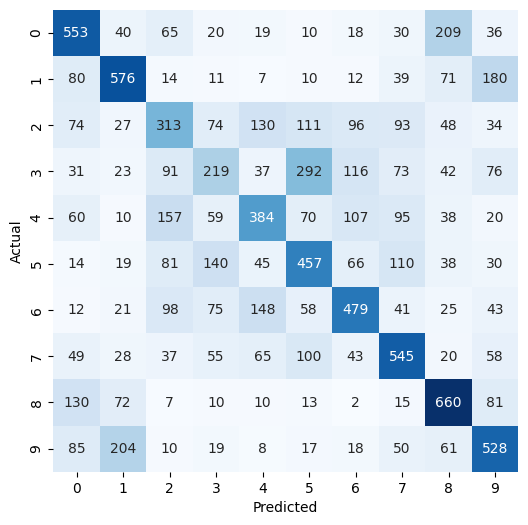

In [40]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Basic ViT on CIFAR100

```
Using mps device
Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 [Training]: 100%|██████████| 157/157 [00:57<00:00,  2.72it/s]
Epoch 1/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 1/10 - Train Loss: 4.3066, Train Acc: 0.0400, Val Loss: 4.1651, Val Acc: 0.0550
Epoch 2/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.89it/s]
Epoch 2/10 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]
Epoch 2/10 - Train Loss: 4.0617, Train Acc: 0.0691, Val Loss: 4.0109, Val Acc: 0.0771
Epoch 3/10 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 3/10 [Validation]: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]
Epoch 3/10 - Train Loss: 3.8970, Train Acc: 0.0916, Val Loss: 3.8267, Val Acc: 0.1059
Epoch 4/10 [Training]: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch 4/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 4/10 - Train Loss: 3.7681, Train Acc: 0.1122, Val Loss: 3.7670, Val Acc: 0.1110
Epoch 5/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
Epoch 5/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 5/10 - Train Loss: 3.6626, Train Acc: 0.1313, Val Loss: 3.6893, Val Acc: 0.1302
Epoch 6/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.89it/s]
Epoch 6/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 6/10 - Train Loss: 3.5687, Train Acc: 0.1472, Val Loss: 3.5719, Val Acc: 0.1509
Epoch 7/10 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.91it/s]
Epoch 7/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 7/10 - Train Loss: 3.4968, Train Acc: 0.1585, Val Loss: 3.4868, Val Acc: 0.1704
Epoch 8/10 [Training]: 100%|██████████| 157/157 [00:54<00:00,  2.91it/s]
Epoch 8/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 8/10 - Train Loss: 3.4363, Train Acc: 0.1708, Val Loss: 3.4952, Val Acc: 0.1668
Epoch 9/10 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 9/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 9/10 - Train Loss: 3.3775, Train Acc: 0.1813, Val Loss: 3.4168, Val Acc: 0.1785
Epoch 10/10 [Training]: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]
Epoch 10/10 [Validation]: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Epoch 10/10 - Train Loss: 3.3281, Train Acc: 0.1908, Val Loss: 3.3996, Val Acc: 0.1848
Total training time: 14.26 minutes
```

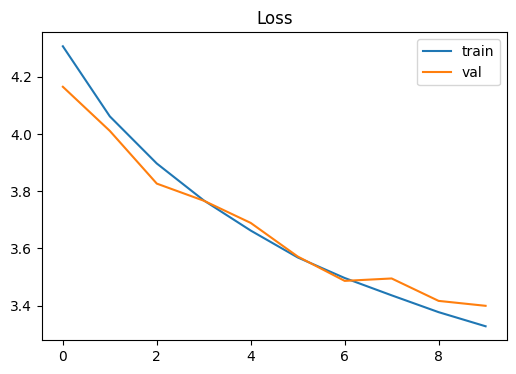

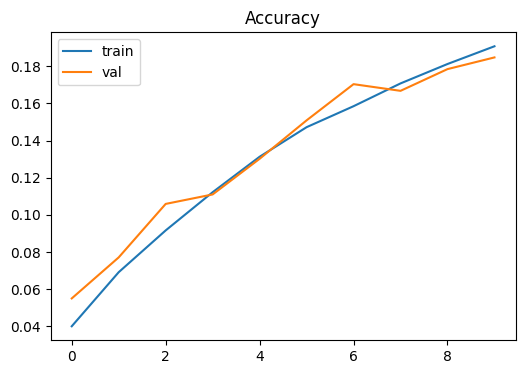

In [76]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [77]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(labels, preds))

# Print confusion matrix - can't print a confusion matrix because 100 classes :(
# cm = confusion_matrix(labels, preds)
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Testing: 40it [00:22,  1.75it/s]

Test accuracy: 0.2032
              precision    recall  f1-score   support

           0       0.23      0.39      0.29       100
           1       0.23      0.24      0.24       100
           2       0.12      0.19      0.15       100
           3       0.07      0.02      0.03       100
           4       0.10      0.07      0.08       100
           5       0.12      0.28      0.17       100
           6       0.20      0.04      0.07       100
           7       0.25      0.16      0.20       100
           8       0.11      0.16      0.13       100
           9       0.44      0.16      0.24       100
          10       0.00      0.00      0.00       100
          11       0.25      0.06      0.10       100
          12       0.18      0.11      0.14       100
          13       0.13      0.22      0.16       100
          14       0.12      0.10      0.11       100
          15       0.16      0.12      0.14       100
          16       0.35      0.12      0.18       100
     